<a href="https://colab.research.google.com/github/ayushm-agrawal/Federated-Learning-Implementations/blob/master/FedProx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How to Navigate through this notebook...

  Start by collapsing all the cells in Google Colab. This will allow you to easily navigate through different parts that might be useful for you.

The main sections of this notebook are listed below
<dl>
  <dt><b>Imports</b></dt>
  <dd>- Contains all the necessary imports</dd>

  <dt><b>Re-Format Time</b></dt>
  <dd>- Functions to format time in a readable format.</dd>
  <dt><b>Load the MNIST Dataset</b></dt>
  <dd>- Load the MNIST Train and Test Dataset from the Torchvision Datasets</dd>
  <dt><b>Visualize Data</b></dt>
  <dd>- Load the first few images from the train and test dataset as a sanity check.</dd>
  <dt><b>Partitioning the Data (IID and non-IID)</b></dt>
  <dd>- Two functions defined to replicate data partitioning in real world scenario.</dd>
  <dd>- IID: Identical and Independent Dataset, generally provides a uniform distribution to the dataset.</dd>
  <dd>- non-IID: This is a pathological implementation where each client in a Federated Learning Scenario gets data from only a subset of classes and not all.</dd>
  <dt><b>Models</b></dt>
  <dd>- MNIST 2NN: Multi-Layer Perceptron replicated from the FedAvg paper.</dd> 
  <dd>- MNIST CNN: Two layer CNN model replicated from the FedAvg paper.</dd>
  <dt><b>Testing Loop</b></dt>
  <dd>- We use this test loop at every epoch to stop our model from overfittin.</dd>
  <dt><b>FedProx</b></dt>
  <dd>- This block contains the entire implementation of the FedProx algorithm as discussed in the paper.</dd>
  <dd>- Different functions are implemented to replicate heterogeneity as mentioned in the FedProx paper</dd>
  <dd>- Client Update function is used to train local clients</dd>
  <dd>- Server Side Update function takes the local models by clients and updates the global model</dd>

  > <b>NOTE: FROM HERE WE START RUNNING DIFFERENT TESTS ON FEDPROX ALGORITHM</b>

  > <u>For each experiment, please check the hyperparameters used and update as necessary.</u>

  <dt><b>Special Case for FedProx</b></dt>
  <dd>- In this case, FedProx acts like FedAvg</dd>
  <dt><b>Training with 0% Probability</b></dt>
  <dd>- Run tests for CNN and MLP models for IID and non-IID dataset when there are no stragglers.</dd>
  <dt><b>Training with 50% Probability</b></dt>
  <dd>- Run tests for CNN and MLP models for IID and non-IID dataset when there are 50% stragglers.</dd>
  <dt><b>Training with 90% Probability</b></dt>
  <dd>- Run tests for CNN and MLP models for IID and non-IID dataset when there are 90% stragglers.</dd>

  <dt><b>Comparison of FedAvg and FedProx on IID Dataset Partition</b></dt>
  <dd>- Run tests to achieve target accuracy on FedAvg and FedProx under highly heteregeneous system.</dd>
  <dt><b>Comparison of FedAvg and FedProx on non-IID Dataset Paritition</b></dt>
  <dd>- Run tests to achieve target accuracy on FedAvg and FedProx under highly heteregeneous system.</dd>

## Imports

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from datetime import datetime, timedelta

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Wed Aug 12 15:19:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Re-Format Time

In [2]:
def get_time_format(seconds):
    sec = timedelta(seconds=int(seconds))
    d = datetime(1, 1, 1) + sec
    if d.day-1 == 1:
        return "%.2d:%.2d:%.2d:%.2d" % (d.day-1, d.hour, d.minute, d.second)
    return "%.2d:%.2d:%.2d" % (d.hour, d.minute, d.second)


def calculate_time(start_time):
    return get_time_format(time.time() - start_time)

## Load the MNIST Dataset

In [3]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw
Processing...
Done!


In [4]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [5]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [6]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [7]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


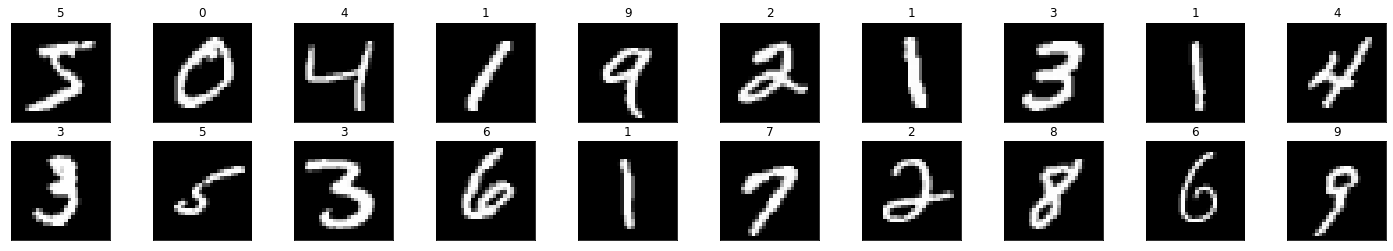

In [8]:
visualize(mnist_data_train)

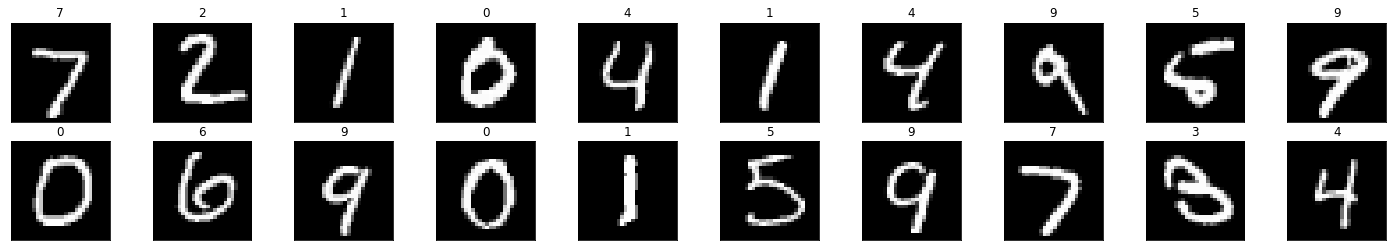

In [9]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [10]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [11]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

## Models

In [12]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [13]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [14]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## Testing Loop

In [15]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  # print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  # for i in range(10):
  #   if total_class[i]>0:
  #     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
  #           (classes[i], 100 * correct_class[i] / total_class[i],
  #           np.sum(correct_class[i]), np.sum(total_class[i])))
  #   else:
  #     print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  # print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
  #       100. * np.sum(correct_class) / np.sum(total_class),
  #       np.sum(correct_class), np.sum(total_class)))
  return test_loss, test_accuracy

## FedProx

### Systems Heterogeneity Simulations

Generate epochs for selected clients based on percentage of devices that corresponds to heterogeneity. 

Assign x number of epochs (chosen unifirmly at random between [1, E]) to 0%, 50% or 90% of the selected devices, respectively. Settings where 0% devices perform fewer than E epochs of work correspond to the environments without system heterogeneity, while 90% of the devices sending their partial solutions corresponds to highly heterogenous system.

In [16]:
def GenerateLocalEpochs(percentage, size, max_epochs):
  ''' Method generates list of epochs for selected clients
  to replicate system heteroggeneity

  Params:
    percentage: percentage of clients to have fewer than E epochs
    size:       total size of the list
    max_epochs: maximum value for local epochs
  
  Returns:
    List of size epochs for each Client Update

  '''

  # if percentage is 0 then each client runs for E epochs
  if percentage == 0:
      return np.array([max_epochs]*size)
  else:
    # get the number of clients to have fewer than E epochs
    heterogenous_size = int((percentage/100) * size)

    # generate random uniform epochs of heterogenous size between 1 and E
    epoch_list = np.random.randint(1, max_epochs, heterogenous_size)

    # the rest of the clients will have E epochs
    remaining_size = size - heterogenous_size
    rem_list = [max_epochs]*remaining_size

    epoch_list = np.append(epoch_list, rem_list, axis=0)
    
    # shuffle the list and return
    np.random.shuffle(epoch_list)

    return epoch_list

### Local Training (Client Update)

Local training for the model on client side

In [17]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, mu, algorithm):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
    self.algorithm = algorithm
    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    # print("Client training for {} epochs.".format(self.epochs))
    criterion = nn.CrossEntropyLoss()
    proximal_criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    # use the weights of global model for proximal term calculation
    global_model = copy.deepcopy(model)

    # calculate local training time
    start_time = time.time()


    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)

        # calculate the loss + the proximal term
        _, pred = torch.max(output, 1)

        if self.algorithm == 'fedprox':
          proximal_term = 0.0

          # iterate through the current and global model parameters
          for w, w_t in zip(model.parameters(), global_model.parameters()) :
            # update the proximal term 
            #proximal_term += torch.sum(torch.abs((w-w_t)**2))
            proximal_term += (w-w_t).norm(2)

          loss = criterion(output, labels) + (mu/2)*proximal_term
        else:
          loss = criterion(output, labels)
    
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss, (time.time() - start_time)

### Server Side Training

Following Algorithm 1 from the paper

In [18]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_data_dict, C, K, E, mu, percentage, plt_title, plt_color, target_test_accuracy, algorithm="fedprox"):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_data_dict:  Data used for testing the model
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - mu:              proximal term constant
    - percentage:      percentage of selected client to have fewer than E epochs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # test accuracy
  test_acc = []

  # store last loss for convergence
  last_loss = 0.0

  # total time taken 
  total_time = 0

  print(f"System heterogeneity set to {percentage}% stragglers.\n")
  print(f"Picking {max(int(C*K),1 )} random clients per round.\n")

  for curr_round in range(1, rounds+1):
    w, local_loss, lst_local_train_time = [], [], []

    m = max(int(C*K), 1)

    heterogenous_epoch_list = GenerateLocalEpochs(percentage, size=m, max_epochs=E)
    heterogenous_epoch_list = np.array(heterogenous_epoch_list)

    S_t = np.random.choice(range(K), m, replace=False)
    S_t = np.array(S_t)
    
    # For Federated Averaging, drop all the clients that are stragglers
    if algorithm == 'fedavg':
      stragglers_indices = np.argwhere(heterogenous_epoch_list < E)
      heterogenous_epoch_list = np.delete(heterogenous_epoch_list, stragglers_indices)
      S_t = np.delete(S_t, stragglers_indices)

    for k, epoch in zip(S_t, heterogenous_epoch_list):
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=epoch, idxs=data_dict[k], mu=mu, algorithm=algorithm)
      weights, loss, local_train_time = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      lst_local_train_time.append(local_train_time)

    # calculate time to update the global weights
    global_start_time = time.time()

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    global_end_time = time.time()

    # calculate total time 
    total_time += (global_end_time - global_start_time) + sum(lst_local_train_time)/len(lst_local_train_time)

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)

    # test accuracy
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy = testing(model, test_data_dict, 128, criterion, num_classes, classes_test)
    


    print(f"Round: {curr_round}... \tAverage Train Loss: {round(loss_avg, 3)}... \tTest Loss: {test_loss}... \tTest Accuracy: {test_accuracy}")
    train_loss.append(loss_avg)

    test_acc.append(test_accuracy)
    # break if we achieve the target test accuracy
    if test_accuracy >= target_test_accuracy:
      rounds = curr_round
      break

    # break if we achieve convergence, i.e., loss between two consecutive rounds is <0.0001
    if algorithm == 'fedprox' and abs(loss_avg - last_loss) < 0.0001:
      rounds = curr_round
      break
    
    # update the last loss
    last_loss = loss_avg

  # plot train loss
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'.jpg', format='jpg')

  # plot test accuracy
  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, rounds+1)
  y_axis1 = np.array(test_acc)
  ax1.plot(x_axis1, y_axis1)

  ax1.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax1.grid()
  fig1.savefig(plt_title+'-test.jpg', format='jpg')
  
  print("Training Done!")
  # print("Total time taken to Train: {}".format(get_time_format(total_time)))

  return model 

## Special Case of FedProx with mu = 0 where it is Federated Averaging

### Train


System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.255... 	Test Loss: 0.1682491548925638... 	Test Accuracy: 95.69620253164557
Round: 2... 	Average Train Loss: 0.041... 	Test Loss: 0.1270620659807697... 	Test Accuracy: 97.34177215189874
Round: 3... 	Average Train Loss: 0.03... 	Test Loss: 0.1009558584760176... 	Test Accuracy: 97.59493670886076
Round: 4... 	Average Train Loss: 0.021... 	Test Loss: 0.08788339576094877... 	Test Accuracy: 97.84810126582279
Round: 5... 	Average Train Loss: 0.017... 	Test Loss: 0.0806972319102846... 	Test Accuracy: 97.9746835443038
Round: 6... 	Average Train Loss: 0.015... 	Test Loss: 0.07215070306889247... 	Test Accuracy: 97.84810126582279
Round: 7... 	Average Train Loss: 0.015... 	Test Loss: 0.06769896842179877... 	Test Accuracy: 98.48101265822785
Round: 8... 	Average Train Loss: 0.014... 	Test Loss: 0.05974470126784727... 	Test Accuracy: 98.60759493670886
Round: 9... 	Average Train Loss: 0.0

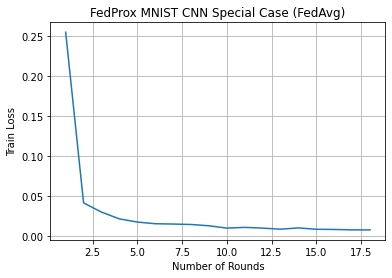

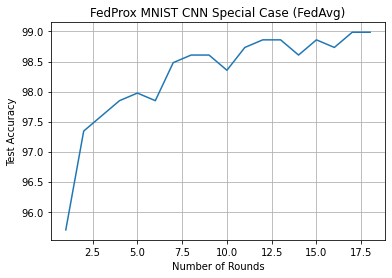

In [19]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.0
# percentage of clients to have fewer than E epochs
percentage = 0
# target test accuracy
target_test_accuracy=99.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN Special Case (FedAvg)", "orange", target_test_accuracy)

 # Training with 0% probability of system heterogeneity

## MNIST CNN on IID

### Train


System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.286... 	Test Loss: 0.15677423682063818... 	Test Accuracy: 96.07594936708861
Round: 2... 	Average Train Loss: 0.054... 	Test Loss: 0.12309533291310072... 	Test Accuracy: 97.46835443037975
Round: 3... 	Average Train Loss: 0.034... 	Test Loss: 0.10244630348230713... 	Test Accuracy: 97.72151898734177
Round: 4... 	Average Train Loss: 0.035... 	Test Loss: 0.08234688316583634... 	Test Accuracy: 97.59493670886076
Round: 5... 	Average Train Loss: 0.031... 	Test Loss: 0.07274353896492394... 	Test Accuracy: 97.9746835443038
Round: 6... 	Average Train Loss: 0.025... 	Test Loss: 0.07058423596122303... 	Test Accuracy: 98.22784810126582
Round: 7... 	Average Train Loss: 0.021... 	Test Loss: 0.06626725818404229... 	Test Accuracy: 98.10126582278481
Round: 8... 	Average Train Loss: 0.023... 	Test Loss: 0.06061577648965758... 	Test Accuracy: 98.48101265822785
Round: 9... 	Average Train Loss

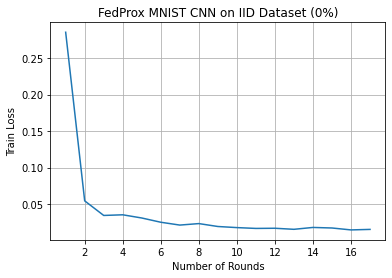

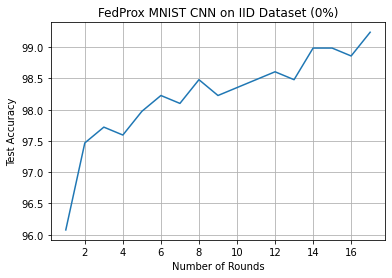

In [20]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0
# target_test_accuracy
target_test_accuracy=99.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on IID Dataset (0%)", "orange", target_test_accuracy)

## MNIST CNN on Non IID

### Train


System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.049... 	Test Loss: 2.9775880100250243... 	Test Accuracy: 26.075949367088608
Round: 2... 	Average Train Loss: 0.032... 	Test Loss: 2.091098132324219... 	Test Accuracy: 27.59493670886076
Round: 3... 	Average Train Loss: 0.03... 	Test Loss: 1.4389735929489136... 	Test Accuracy: 50.63291139240506
Round: 4... 	Average Train Loss: 0.024... 	Test Loss: 1.5055664682388306... 	Test Accuracy: 55.31645569620253
Round: 5... 	Average Train Loss: 0.017... 	Test Loss: 1.0132979842185974... 	Test Accuracy: 63.79746835443038
Round: 6... 	Average Train Loss: 0.015... 	Test Loss: 0.589519287443161... 	Test Accuracy: 80.12658227848101
Round: 7... 	Average Train Loss: 0.012... 	Test Loss: 0.5778641642093658... 	Test Accuracy: 80.88607594936708
Round: 8... 	Average Train Loss: 0.014... 	Test Loss: 0.4602468936443329... 	Test Accuracy: 84.68354430379746
Round: 9... 	Average Train Loss: 0.014..

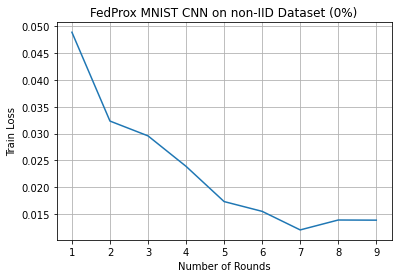

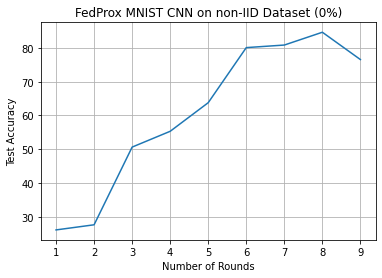

In [21]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0

# target_test_accuracy
target_test_accuracy=99.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (0%)", "green", target_test_accuracy)


## MNIST MLP on IID

### Train

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.597... 	Test Loss: 0.33981159615516665... 	Test Accuracy: 90.50632911392405
Round: 2... 	Average Train Loss: 0.19... 	Test Loss: 0.295352877998352... 	Test Accuracy: 92.65822784810126
Round: 3... 	Average Train Loss: 0.165... 	Test Loss: 0.2759601198077202... 	Test Accuracy: 93.16455696202532
Round: 4... 	Average Train Loss: 0.152... 	Test Loss: 0.25294016422331334... 	Test Accuracy: 92.9113924050633
Round: 5... 	Average Train Loss: 0.112... 	Test Loss: 0.23895647785663604... 	Test Accuracy: 93.29113924050633
Round: 6... 	Average Train Loss: 0.072... 	Test Loss: 0.2299989909812808... 	Test Accuracy: 93.92405063291139
Round: 7... 	Average Train Loss: 0.135... 	Test Loss: 0.21545796639323234... 	Test Accuracy: 94.0506329113924
Training Done!


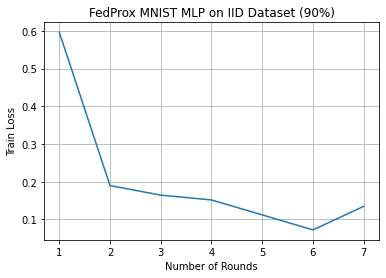

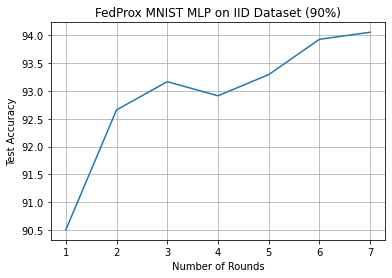

In [22]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on IID Dataset (90%)", "orange", target_test_accuracy)


## MNIST MLP on Non IID

### Train

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.248... 	Test Loss: 3.7023820693969727... 	Test Accuracy: 20.759493670886076
Round: 2... 	Average Train Loss: 0.115... 	Test Loss: 3.390885832977295... 	Test Accuracy: 23.29113924050633
Round: 3... 	Average Train Loss: 0.034... 	Test Loss: 2.566848978805542... 	Test Accuracy: 36.70886075949367
Round: 4... 	Average Train Loss: 0.054... 	Test Loss: 1.6602831937789917... 	Test Accuracy: 54.68354430379747
Round: 5... 	Average Train Loss: 0.039... 	Test Loss: 1.1001135723114013... 	Test Accuracy: 57.721518987341774
Round: 6... 	Average Train Loss: 0.042... 	Test Loss: 1.0657608781814576... 	Test Accuracy: 62.151898734177216
Round: 7... 	Average Train Loss: 0.035... 	Test Loss: 0.8269805119514465... 	Test Accuracy: 71.13924050632912
Round: 8... 	Average Train Loss: 0.037... 	Test Loss: 0.9334937385559082... 	Test Accuracy: 63.54430379746835
Round: 9... 	Average Train Loss: 0.0

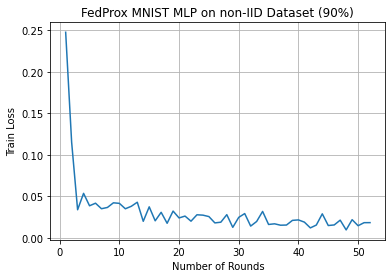

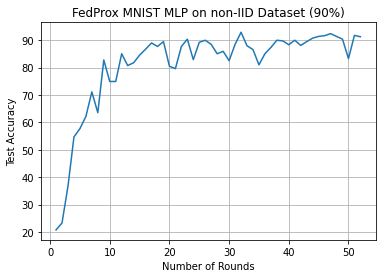

In [23]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on non-IID Dataset (90%)", "green", target_test_accuracy)

# Training with 50% probability of system heterogeneity

## MNIST CNN on IID

### Train


System heterogeneity set to 50% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.447... 	Test Loss: 0.17414842083454132... 	Test Accuracy: 95.0632911392405
Round: 2... 	Average Train Loss: 0.106... 	Test Loss: 0.11909288570284843... 	Test Accuracy: 96.83544303797468
Round: 3... 	Average Train Loss: 0.066... 	Test Loss: 0.09787474223300814... 	Test Accuracy: 97.21518987341773
Round: 4... 	Average Train Loss: 0.044... 	Test Loss: 0.0854887622129987... 	Test Accuracy: 97.59493670886076
Round: 5... 	Average Train Loss: 0.057... 	Test Loss: 0.07197073401981033... 	Test Accuracy: 98.10126582278481
Round: 6... 	Average Train Loss: 0.03... 	Test Loss: 0.06523324645482353... 	Test Accuracy: 98.22784810126582
Round: 7... 	Average Train Loss: 0.027... 	Test Loss: 0.06482798097054474... 	Test Accuracy: 98.60759493670886
Round: 8... 	Average Train Loss: 0.04... 	Test Loss: 0.058713185988122134... 	Test Accuracy: 98.73417721518987
Round: 9... 	Average Train Loss:

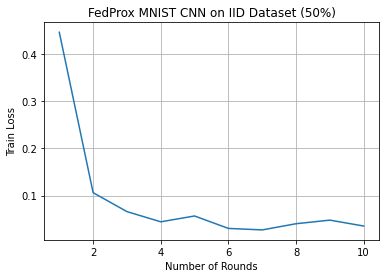

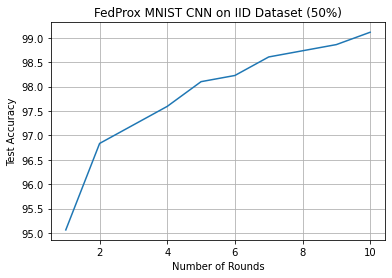

In [24]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 50
# target_test_accuracy
target_test_accuracy=99.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on IID Dataset (50%)", "orange", target_test_accuracy)

## MNIST CNN on Non IID

### Train


System heterogeneity set to 50% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.063... 	Test Loss: 2.104177982711792... 	Test Accuracy: 28.10126582278481
Round: 2... 	Average Train Loss: 0.035... 	Test Loss: 2.0645568244934083... 	Test Accuracy: 40.25316455696203
Round: 3... 	Average Train Loss: 0.031... 	Test Loss: 1.3013924940109254... 	Test Accuracy: 60.50632911392405
Round: 4... 	Average Train Loss: 0.02... 	Test Loss: 2.260540909194946... 	Test Accuracy: 29.873417721518987
Round: 5... 	Average Train Loss: 0.014... 	Test Loss: 1.1929788646697999... 	Test Accuracy: 59.36708860759494
Round: 6... 	Average Train Loss: 0.021... 	Test Loss: 0.6739433184623719... 	Test Accuracy: 78.22784810126582
Round: 7... 	Average Train Loss: 0.024... 	Test Loss: 0.7578722602844238... 	Test Accuracy: 74.17721518987342
Round: 8... 	Average Train Loss: 0.029... 	Test Loss: 0.622692104101181... 	Test Accuracy: 76.45569620253164
Round: 9... 	Average Train Loss: 0.022..

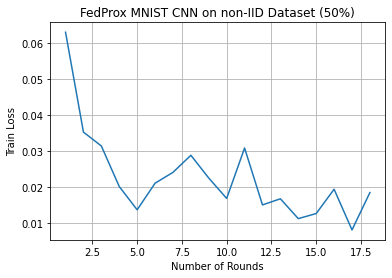

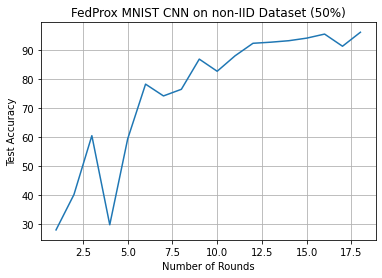

In [25]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 50
# target_test_accuracy
target_test_accuracy=96.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (50%)", "green", target_test_accuracy)


## MNIST MLP on IID

### Train

System heterogeneity set to 50% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 1.023... 	Test Loss: 0.674980073261261... 	Test Accuracy: 83.29113924050633
Round: 2... 	Average Train Loss: 0.155... 	Test Loss: 0.3039632867515087... 	Test Accuracy: 92.15189873417721
Round: 3... 	Average Train Loss: 0.085... 	Test Loss: 0.2791133965432644... 	Test Accuracy: 93.29113924050633
Round: 4... 	Average Train Loss: 0.098... 	Test Loss: 0.26072224661409854... 	Test Accuracy: 93.41772151898734
Round: 5... 	Average Train Loss: 0.086... 	Test Loss: 0.24342278826087713... 	Test Accuracy: 93.29113924050633
Round: 6... 	Average Train Loss: 0.091... 	Test Loss: 0.22526649805903434... 	Test Accuracy: 93.67088607594937
Round: 7... 	Average Train Loss: 0.113... 	Test Loss: 0.21335024886131287... 	Test Accuracy: 93.67088607594937
Round: 8... 	Average Train Loss: 0.054... 	Test Loss: 0.20204983824044467... 	Test Accuracy: 94.68354430379746
Training Done!


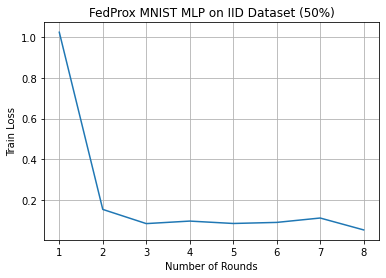

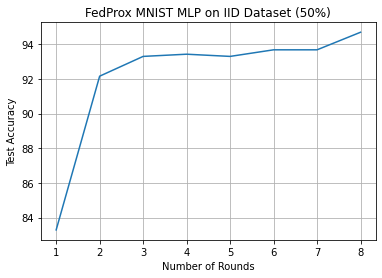

In [26]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 50
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on IID Dataset (50%)", "orange", target_test_accuracy)


## MNIST MLP on Non IID

### Train

System heterogeneity set to 50% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.168... 	Test Loss: 3.712359524536133... 	Test Accuracy: 18.9873417721519
Round: 2... 	Average Train Loss: 0.036... 	Test Loss: 3.0823422039031985... 	Test Accuracy: 31.772151898734176
Round: 3... 	Average Train Loss: 0.046... 	Test Loss: 1.894597993659973... 	Test Accuracy: 57.848101265822784
Round: 4... 	Average Train Loss: 0.031... 	Test Loss: 2.049077114868164... 	Test Accuracy: 34.050632911392405
Round: 5... 	Average Train Loss: 0.022... 	Test Loss: 1.3539307416915893... 	Test Accuracy: 66.07594936708861
Round: 6... 	Average Train Loss: 0.03... 	Test Loss: 1.1763375792503357... 	Test Accuracy: 56.58227848101266
Round: 7... 	Average Train Loss: 0.017... 	Test Loss: 0.887056803894043... 	Test Accuracy: 66.20253164556962
Round: 8... 	Average Train Loss: 0.024... 	Test Loss: 0.553860544538498... 	Test Accuracy: 82.27848101265823
Round: 9... 	Average Train Loss: 0.039...

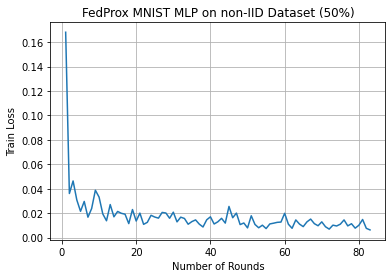

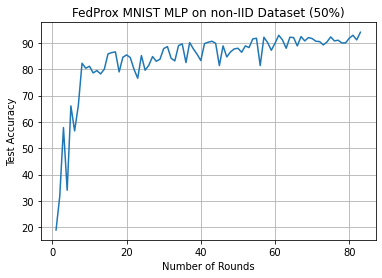

In [27]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 50
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on non-IID Dataset (50%)", "green", target_test_accuracy)

# Training with 90% probability of system heterogeneity

## MNIST CNN on IID

### Train


System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.458... 	Test Loss: 0.17735546071380376... 	Test Accuracy: 94.9367088607595
Round: 2... 	Average Train Loss: 0.13... 	Test Loss: 0.12703009561747314... 	Test Accuracy: 96.70886075949367
Round: 3... 	Average Train Loss: 0.095... 	Test Loss: 0.10612152363434434... 	Test Accuracy: 96.83544303797468
Round: 4... 	Average Train Loss: 0.075... 	Test Loss: 0.08663514154180885... 	Test Accuracy: 97.72151898734177
Training Done!


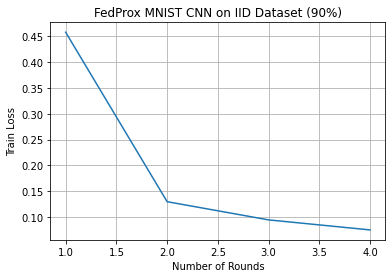

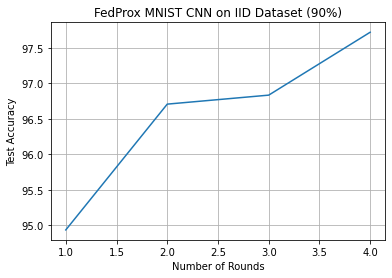

In [28]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target_test_accuracy
target_test_accuracy=97.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on IID Dataset (90%)", "orange", target_test_accuracy)

## MNIST CNN on Non IID

### Train


System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.126... 	Test Loss: 2.171712088394165... 	Test Accuracy: 39.24050632911393
Round: 2... 	Average Train Loss: 0.053... 	Test Loss: 1.7844791311264039... 	Test Accuracy: 42.78481012658228
Round: 3... 	Average Train Loss: 0.05... 	Test Loss: 1.2232531314849853... 	Test Accuracy: 60.25316455696203
Round: 4... 	Average Train Loss: 0.042... 	Test Loss: 1.2373505483627318... 	Test Accuracy: 56.075949367088604
Round: 5... 	Average Train Loss: 0.04... 	Test Loss: 0.7091968745231628... 	Test Accuracy: 71.89873417721519
Round: 6... 	Average Train Loss: 0.034... 	Test Loss: 1.042835661125183... 	Test Accuracy: 65.18987341772151
Round: 7... 	Average Train Loss: 0.027... 	Test Loss: 0.5256869955539704... 	Test Accuracy: 83.92405063291139
Round: 8... 	Average Train Loss: 0.032... 	Test Loss: 0.3803427419185638... 	Test Accuracy: 88.48101265822785
Round: 9... 	Average Train Loss: 0.02...

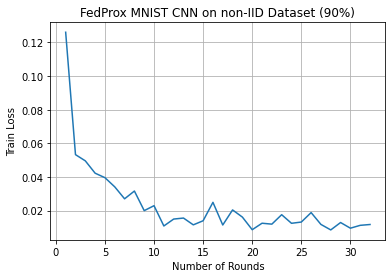

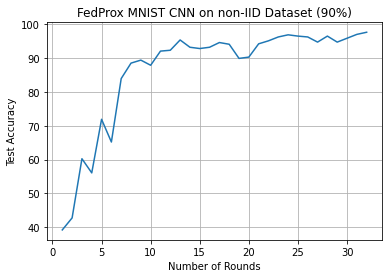

In [29]:
# number of training rounds
rounds = 1000
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# target test accuracy
target_test_accuracy = 97.0
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (90%)", "green", target_test_accuracy)


## MNIST MLP on IID

### Train

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.833... 	Test Loss: 0.3505539712905884... 	Test Accuracy: 89.87341772151899
Round: 2... 	Average Train Loss: 0.185... 	Test Loss: 0.2982291683673859... 	Test Accuracy: 91.77215189873418
Round: 3... 	Average Train Loss: 0.114... 	Test Loss: 0.27757849668860435... 	Test Accuracy: 92.9113924050633
Round: 4... 	Average Train Loss: 0.141... 	Test Loss: 0.25468652298152444... 	Test Accuracy: 93.67088607594937
Round: 5... 	Average Train Loss: 0.098... 	Test Loss: 0.24234317042678594... 	Test Accuracy: 93.41772151898734
Round: 6... 	Average Train Loss: 0.117... 	Test Loss: 0.23247412038445472... 	Test Accuracy: 93.79746835443038
Round: 7... 	Average Train Loss: 0.105... 	Test Loss: 0.20959458766281605... 	Test Accuracy: 94.17721518987342
Training Done!


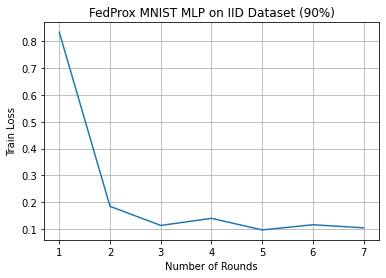

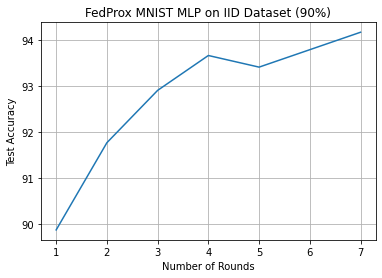

In [30]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on IID Dataset (90%)", "orange", target_test_accuracy)


## MNIST MLP on Non IID

### Train

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.072... 	Test Loss: 3.5024506057739258... 	Test Accuracy: 30.632911392405063
Round: 2... 	Average Train Loss: 0.074... 	Test Loss: 2.408240445327759... 	Test Accuracy: 32.53164556962025
Round: 3... 	Average Train Loss: 0.033... 	Test Loss: 1.5212392637252807... 	Test Accuracy: 56.835443037974684
Round: 4... 	Average Train Loss: 0.049... 	Test Loss: 1.2721297611236573... 	Test Accuracy: 59.620253164556964
Round: 5... 	Average Train Loss: 0.04... 	Test Loss: 1.049706690788269... 	Test Accuracy: 63.037974683544306
Round: 6... 	Average Train Loss: 0.035... 	Test Loss: 0.7717835886955261... 	Test Accuracy: 70.25316455696202
Round: 7... 	Average Train Loss: 0.024... 	Test Loss: 0.9928293849945068... 	Test Accuracy: 68.22784810126582
Round: 8... 	Average Train Loss: 0.03... 	Test Loss: 0.8056202705383301... 	Test Accuracy: 74.55696202531645
Round: 9... 	Average Train Loss: 0.02

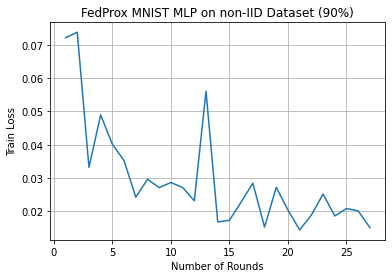

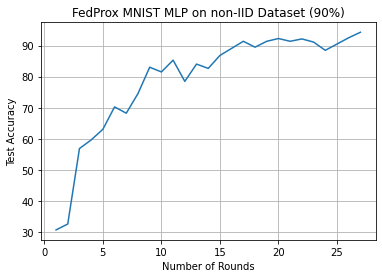

In [31]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.05
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on non-IID Dataset (90%)", "green", target_test_accuracy)

# Comparison with Federated Averaging IID Partition

> In a highly heterogenous system (90%) stragglers, authors of FedProx have claimed that FedProx achieves on average **22%** improvement in testing accuracy compared to Federated Averaging

With our first test above, we know that the special case where **mu=0**, FedProx matches the results of FedAvg. 

We will use the same idea but increase our stragglers this time. We will run the same experiment with **mu > 0** to compare results of FedProx.

### Training Federated Averaging with 90% stragglers (IID Partition)

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.243... 	Test Loss: 0.1800511596955359... 	Test Accuracy: 94.55696202531645
Round: 2... 	Average Train Loss: 0.035... 	Test Loss: 0.14766051300512628... 	Test Accuracy: 96.45569620253164
Round: 3... 	Average Train Loss: 0.035... 	Test Loss: 0.10738021533368156... 	Test Accuracy: 97.21518987341773
Round: 4... 	Average Train Loss: 0.024... 	Test Loss: 0.10633101256506051... 	Test Accuracy: 97.21518987341773
Round: 5... 	Average Train Loss: 0.018... 	Test Loss: 0.10073894104869105... 	Test Accuracy: 97.0886075949367
Round: 6... 	Average Train Loss: 0.016... 	Test Loss: 0.0966373064121406... 	Test Accuracy: 97.34177215189874
Round: 7... 	Average Train Loss: 0.016... 	Test Loss: 0.09341529543192592... 	Test Accuracy: 97.72151898734177
Round: 8... 	Average Train Loss: 0.015... 	Test Loss: 0.0747657953685848... 	Test Accuracy: 97.59493670886076
Round: 9... 	Average Train Loss: 

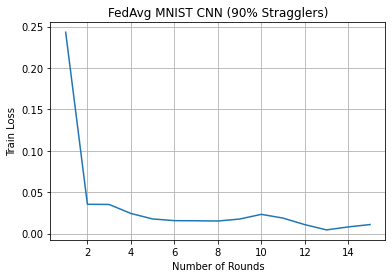

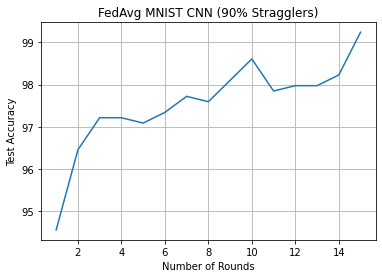

In [32]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.0
# percentage of clients to have fewer than E epochs
percentage = 90
# target test accuracy
target_test_accuracy = 99.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained_fedavg = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedAvg MNIST CNN (90% Stragglers)", "orange", target_test_accuracy, algorithm='fedavg')

### Training FedProx with 90% Stragglers (IID Parition)

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.841... 	Test Loss: 0.23637543864250182... 	Test Accuracy: 92.9113924050633
Round: 2... 	Average Train Loss: 0.114... 	Test Loss: 0.1387696297518909... 	Test Accuracy: 96.70886075949367
Round: 3... 	Average Train Loss: 0.09... 	Test Loss: 0.10665031041502952... 	Test Accuracy: 97.21518987341773
Round: 4... 	Average Train Loss: 0.065... 	Test Loss: 0.091045677876845... 	Test Accuracy: 97.46835443037975
Round: 5... 	Average Train Loss: 0.035... 	Test Loss: 0.08589293542765081... 	Test Accuracy: 97.84810126582279
Round: 6... 	Average Train Loss: 0.065... 	Test Loss: 0.06773719151284313... 	Test Accuracy: 98.10126582278481
Round: 7... 	Average Train Loss: 0.047... 	Test Loss: 0.06703249160738778... 	Test Accuracy: 98.22784810126582
Round: 8... 	Average Train Loss: 0.034... 	Test Loss: 0.06355271759871975... 	Test Accuracy: 98.35443037974683
Round: 9... 	Average Train Loss: 0

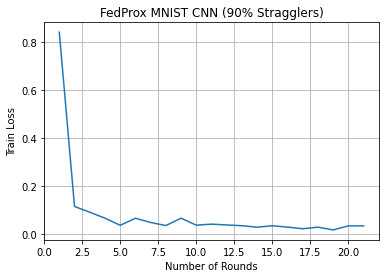

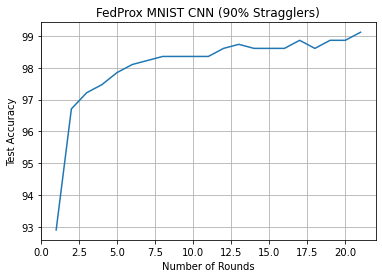

In [33]:
# number of training rounds
rounds = 300
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target test accuracy
target_test_accuracy = 99.0

# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained_fedprox = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN (90% Stragglers)", "green", target_test_accuracy)

# Comparison with Federated Averaging non-IID Partition

> In a highly heterogenous system (90%) stragglers, authors of FedProx have claimed that FedProx achieves on average **22%** improvement in testing accuracy compared to Federated Averaging

With our first test above, we know that the special case where **mu=0**, FedProx matches the results of FedAvg. 

We will use the same idea but increase our stragglers this time. We will run the same experiment with **mu > 0** to compare results of FedProx.

### Training Federated Averaging with 90% stragglers (non-IID Partition)

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.027... 	Test Loss: 10.416439100646972... 	Test Accuracy: 17.59493670886076
Round: 2... 	Average Train Loss: 0.041... 	Test Loss: 7.65616241607666... 	Test Accuracy: 21.772151898734176
Round: 3... 	Average Train Loss: 0.026... 	Test Loss: 7.248042140960694... 	Test Accuracy: 20.759493670886076
Round: 4... 	Average Train Loss: 0.013... 	Test Loss: 7.772884909057617... 	Test Accuracy: 18.10126582278481
Round: 5... 	Average Train Loss: 0.034... 	Test Loss: 8.889501936340332... 	Test Accuracy: 18.354430379746834
Round: 6... 	Average Train Loss: 0.025... 	Test Loss: 10.150454154968262... 	Test Accuracy: 21.0126582278481
Round: 7... 	Average Train Loss: 0.038... 	Test Loss: 7.200136389923096... 	Test Accuracy: 17.59493670886076
Round: 8... 	Average Train Loss: 0.01... 	Test Loss: 6.309183881378174... 	Test Accuracy: 12.025316455696203
Round: 9... 	Average Train Loss: 0.027... 

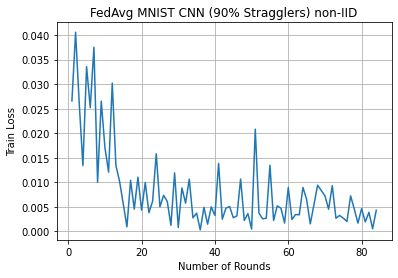

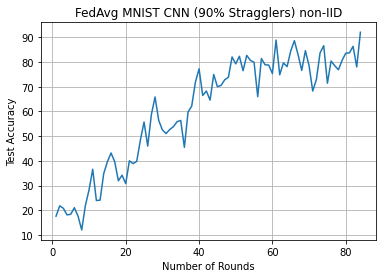

In [34]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.0
# percentage of clients to have fewer than E epochs
percentage = 90
# target test accuracy
target_test_accuracy = 90.0
# data partition dictionary
non_iid_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained_fedavg = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, non_iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedAvg MNIST CNN (90% Stragglers) non-IID", "orange", target_test_accuracy, algorithm='fedavg')

### Training FedProx with 90% Stragglers (non-IID Parition)

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.074... 	Test Loss: 2.3928937355041504... 	Test Accuracy: 15.063291139240507
Round: 2... 	Average Train Loss: 0.049... 	Test Loss: 2.1259401973724366... 	Test Accuracy: 39.49367088607595
Round: 3... 	Average Train Loss: 0.05... 	Test Loss: 1.7753675369262696... 	Test Accuracy: 46.962025316455694
Round: 4... 	Average Train Loss: 0.038... 	Test Loss: 1.0632993242263793... 	Test Accuracy: 63.29113924050633
Round: 5... 	Average Train Loss: 0.025... 	Test Loss: 0.6285026379585266... 	Test Accuracy: 78.86075949367088
Round: 6... 	Average Train Loss: 0.02... 	Test Loss: 0.6191626049041749... 	Test Accuracy: 81.26582278481013
Round: 7... 	Average Train Loss: 0.024... 	Test Loss: 0.6317765829563141... 	Test Accuracy: 76.20253164556962
Round: 8... 	Average Train Loss: 0.033... 	Test Loss: 0.4101809196472168... 	Test Accuracy: 87.72151898734177
Round: 9... 	Average Train Loss: 0.01

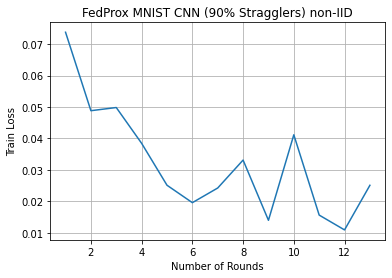

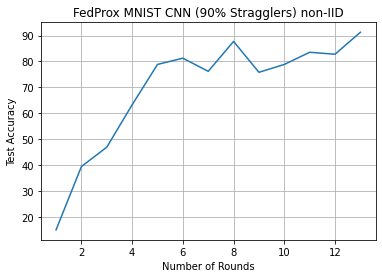

In [35]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target test accuracy
target_test_accuracy = 90.0

# data partition dictionary
non_iid_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained_fedprox = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, non_iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN (90% Stragglers) non-IID", "green", target_test_accuracy)